In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import datetime as dt

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import plotly.express as px
import folium 
import folium.plugins
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import warnings
warnings.filterwarnings("ignore")

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import decomposition
from folium.features import DivIcon
import random

Loading BokehJS ...

In [3]:
# data loading and cleaning
dt1 = pd.read_csv('data/trip_data/trip_data_3.csv')
dt1.drop(columns=' store_and_fwd_flag', inplace=True)
# dt2 = pd.read_csv('data/trip_data/trip_data_2.csv')

df1 = pd.read_csv('data/trip_fare/trip_fare_3.csv')
# df2 = pd.read_csv('data/trip_fare/trip_fare_2.csv')
df = pd.merge(dt1, df1, how='left', on=['medallion', ' hack_license', ' vendor_id', ' pickup_datetime'])
for i in df.columns:
    df.rename(columns={i : i.strip(' ')}, inplace=True)
df['trip_time'] = df['trip_time_in_secs']/60
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    df[i] = df[i].replace(0,np.nan)
df.dropna(inplace=True)
# drop observations less than 0 and  greater than 99.9% percentile value.
df = df[(df["fare_amount"] > 0) & (
    df["fare_amount"] < df["fare_amount"].quantile(.999))]

df = df[(df["trip_distance"] > 0) & (
    df["trip_distance"] < df["trip_distance"].quantile(.9999))]

df = df[(df["trip_time_in_secs"] > 0) & (
    df["trip_time_in_secs"] < df["trip_time_in_secs"].quantile(.9999))]

for i in coord:
    df = df[(df[i] > df[i].quantile(.001)) &
            (df[i] < df[i].quantile(.999))]
    
    
pickupTime = pd.to_datetime(df['pickup_datetime'])
df['hourOfDay'] = pickupTime.dt.hour
df['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
df['dst hourOfDay'] = df['src hourOfDay'] + df['trip_time'] / 60.0

df['dayOfWeek']     = pickupTime.dt.weekday
df['hourOfWeek']    = df['dayOfWeek']*24.0 + df['src hourOfDay']

df['date']     = pickupTime.dt.date
allLat  = np.array(list(df['pickup_latitude'])  + list(df['dropoff_latitude']))
allLong = np.array(list(df['pickup_longitude']) + list(df['dropoff_longitude']))

medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

df['src lat']   = latMultiplier  * (df['pickup_latitude']   - medianLat)
df['src long']  = longMultiplier * (df['pickup_longitude']  - medianLong)
df['dst lat']   = latMultiplier  * (df['dropoff_latitude']  - medianLat)
df['dst long']  = longMultiplier * (df['dropoff_longitude'] - medianLong)
df = df.reset_index(drop=True)

allLat  = np.array(list(df['src lat'])  + list(df['dst lat']))
allLong = np.array(list(df['src long']) + list(df['dst long']))





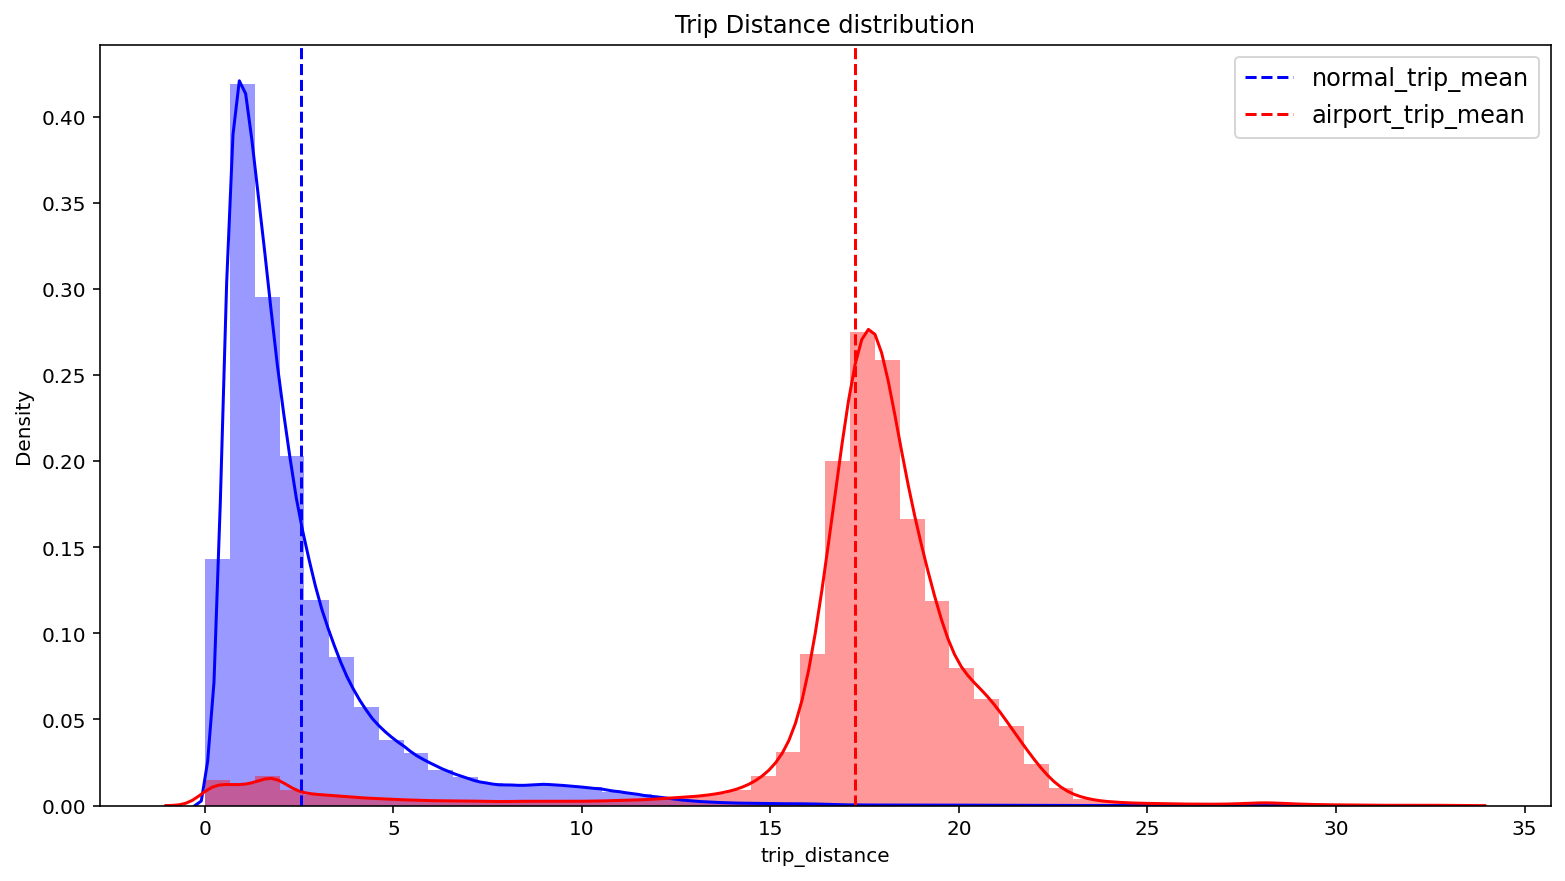

In [4]:
# Plot
plt.figure(figsize = (13,7))
sns.distplot(df[df["rate_code"] == 1]['trip_distance'],color = "b")
sns.distplot(df[df["rate_code"] == 2]['trip_distance'],color = "r")
plt.axvline(df[df["rate_code"] == 1]['trip_distance'].mean(),
            color = "b",linestyle = "dashed",label = "normal_trip_mean")
plt.axvline(df[df["rate_code"] == 2]['trip_distance'].mean(),
            color = "r",linestyle = "dashed",label = "airport_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Trip Distance distribution")
plt.show()

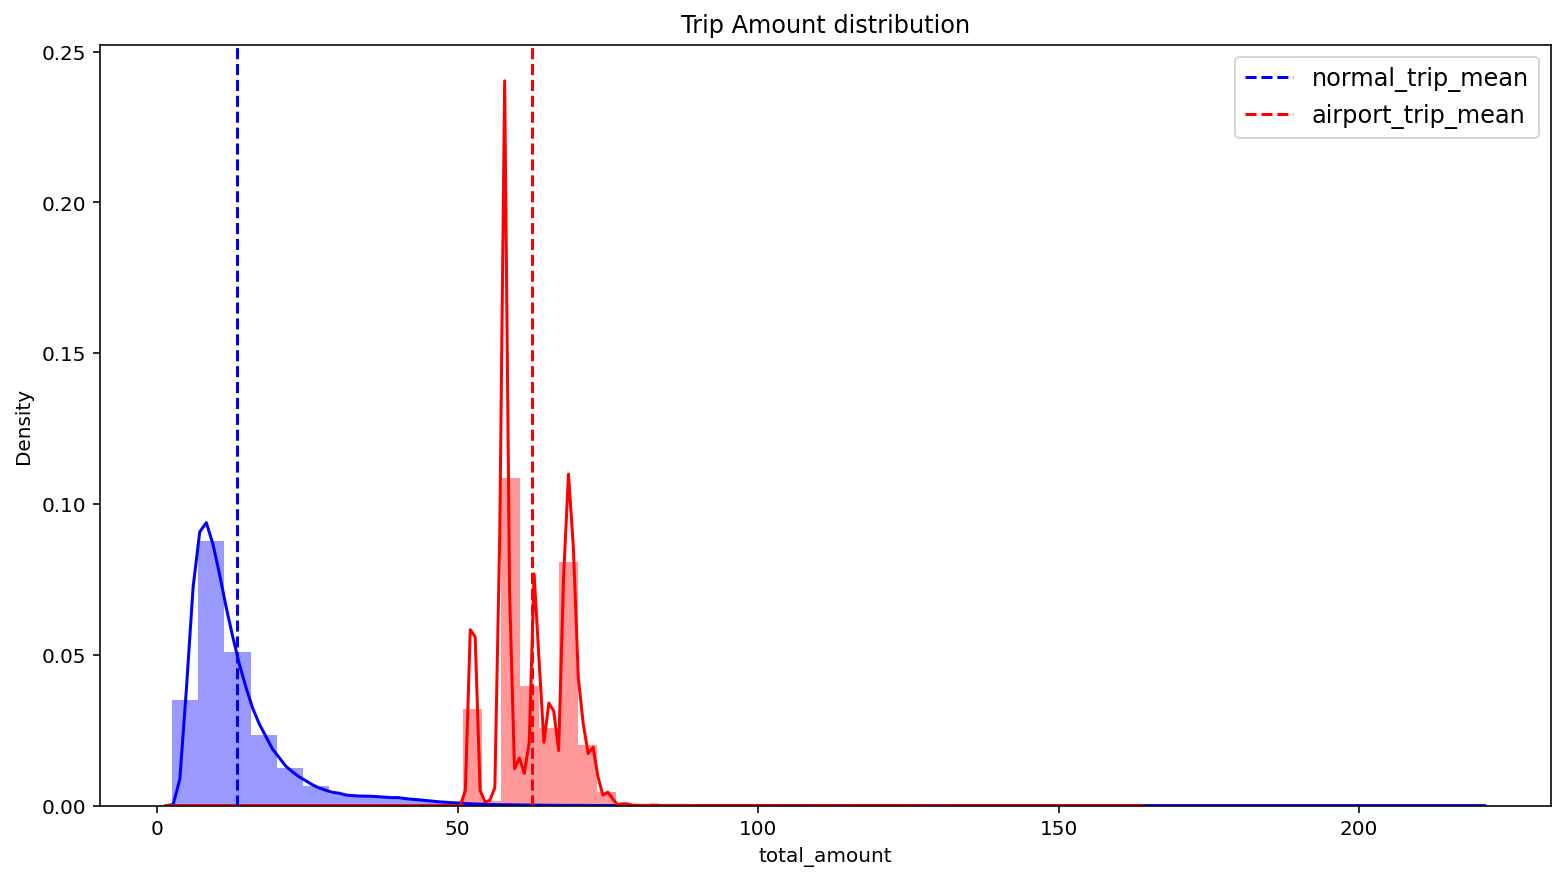

In [5]:
# Plot
plt.figure(figsize = (13,7))
sns.distplot(df[df["rate_code"] == 1]['total_amount'],color = "b")
sns.distplot(df[df["rate_code"] == 2]['total_amount'],color = "r")
plt.axvline(df[df["rate_code"] == 1]['total_amount'].mean(),
            color = "b",linestyle = "dashed",label = "normal_trip_mean")
plt.axvline(df[df["rate_code"] == 2]['total_amount'].mean(),
            color = "r",linestyle = "dashed",label = "airport_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Trip Amount distribution")
plt.show()

In [9]:
# Flight data 
af = pd.read_csv('data/flight_data.csv')
af = af[af['month'] == 3]

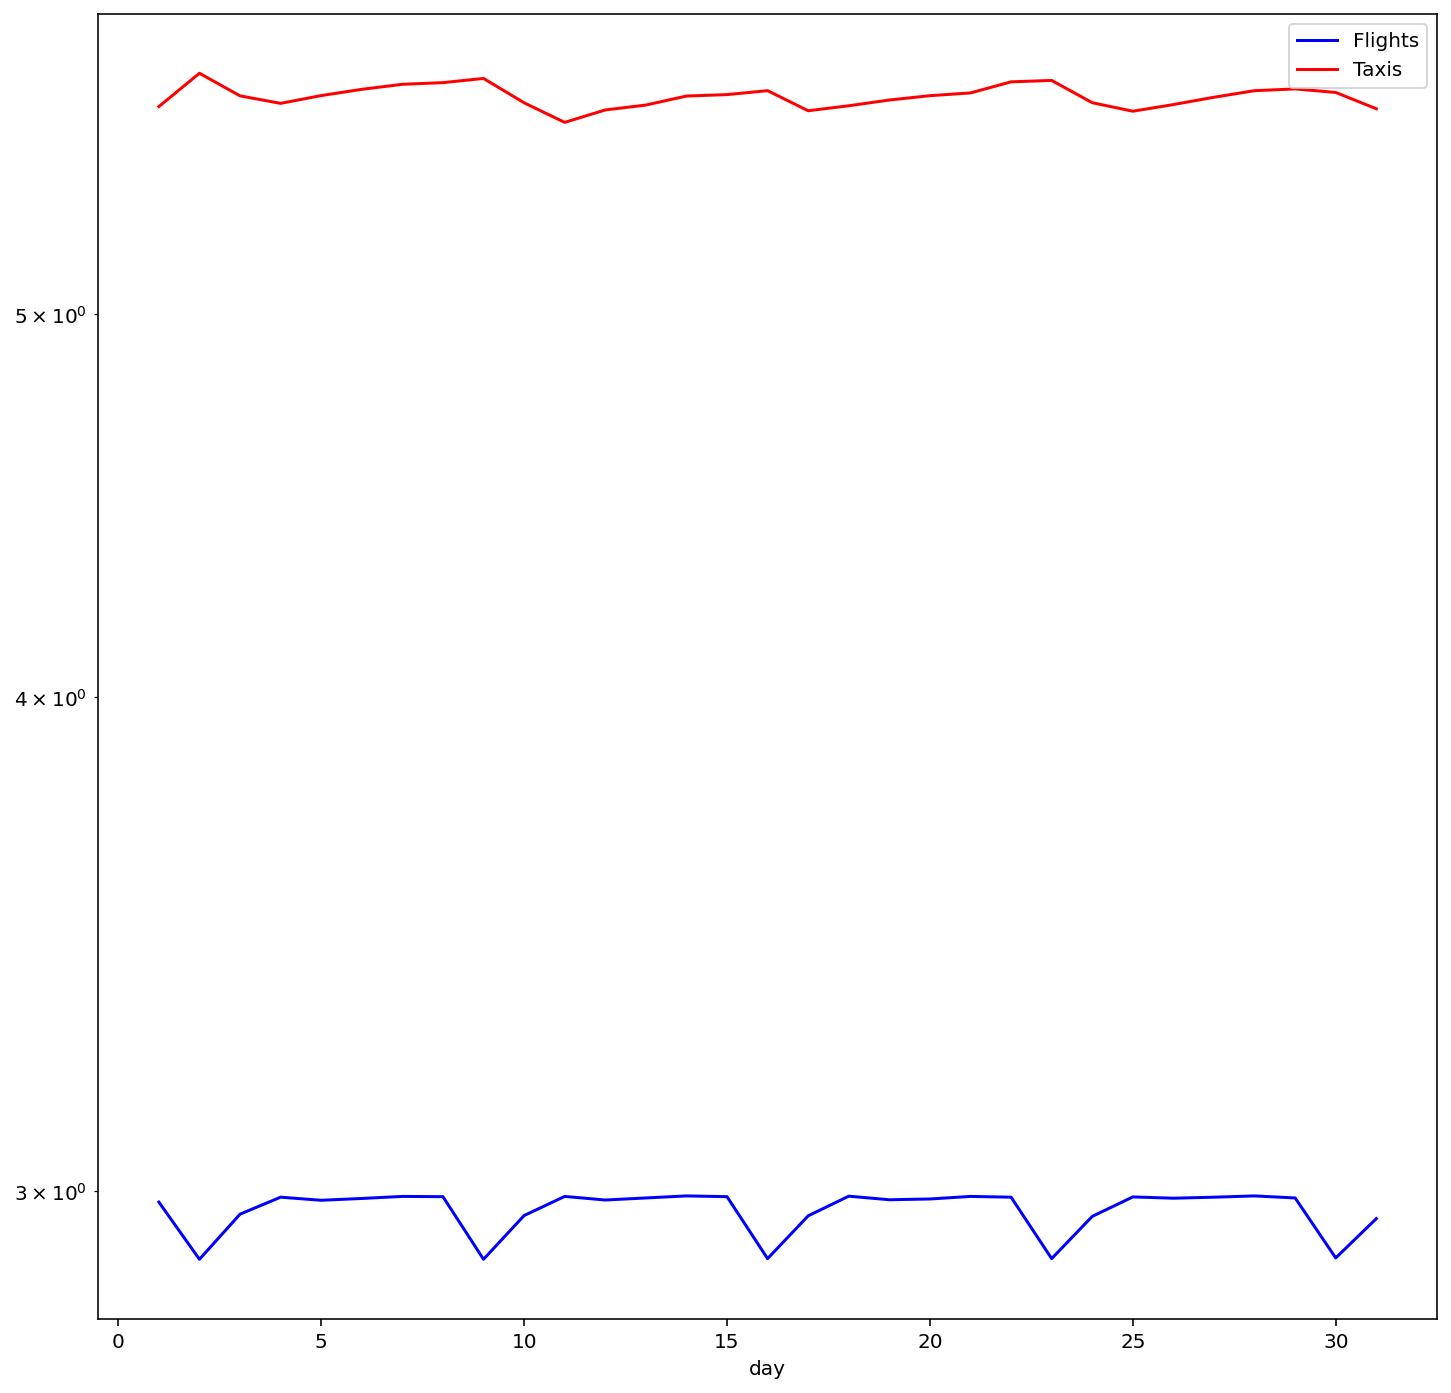

In [12]:
# Plot 
f, ax = plt.subplots(figsize=(12, 12))
ax.set(yscale="log")
sns.lineplot(x=af.groupby('day')['flight'].count().index, y=af.groupby(
    'day')['flight'].count().values, color='blue', label='Flights')
sns.lineplot(x=df.groupby('day')['pickup_longitude'].count(
).index, y=df.groupby('day')['pickup_longitude'].count().values, color = 'red', label='Taxis')
ax.legend()

Text(0.5, 1.0, 'Pickups near the airports')

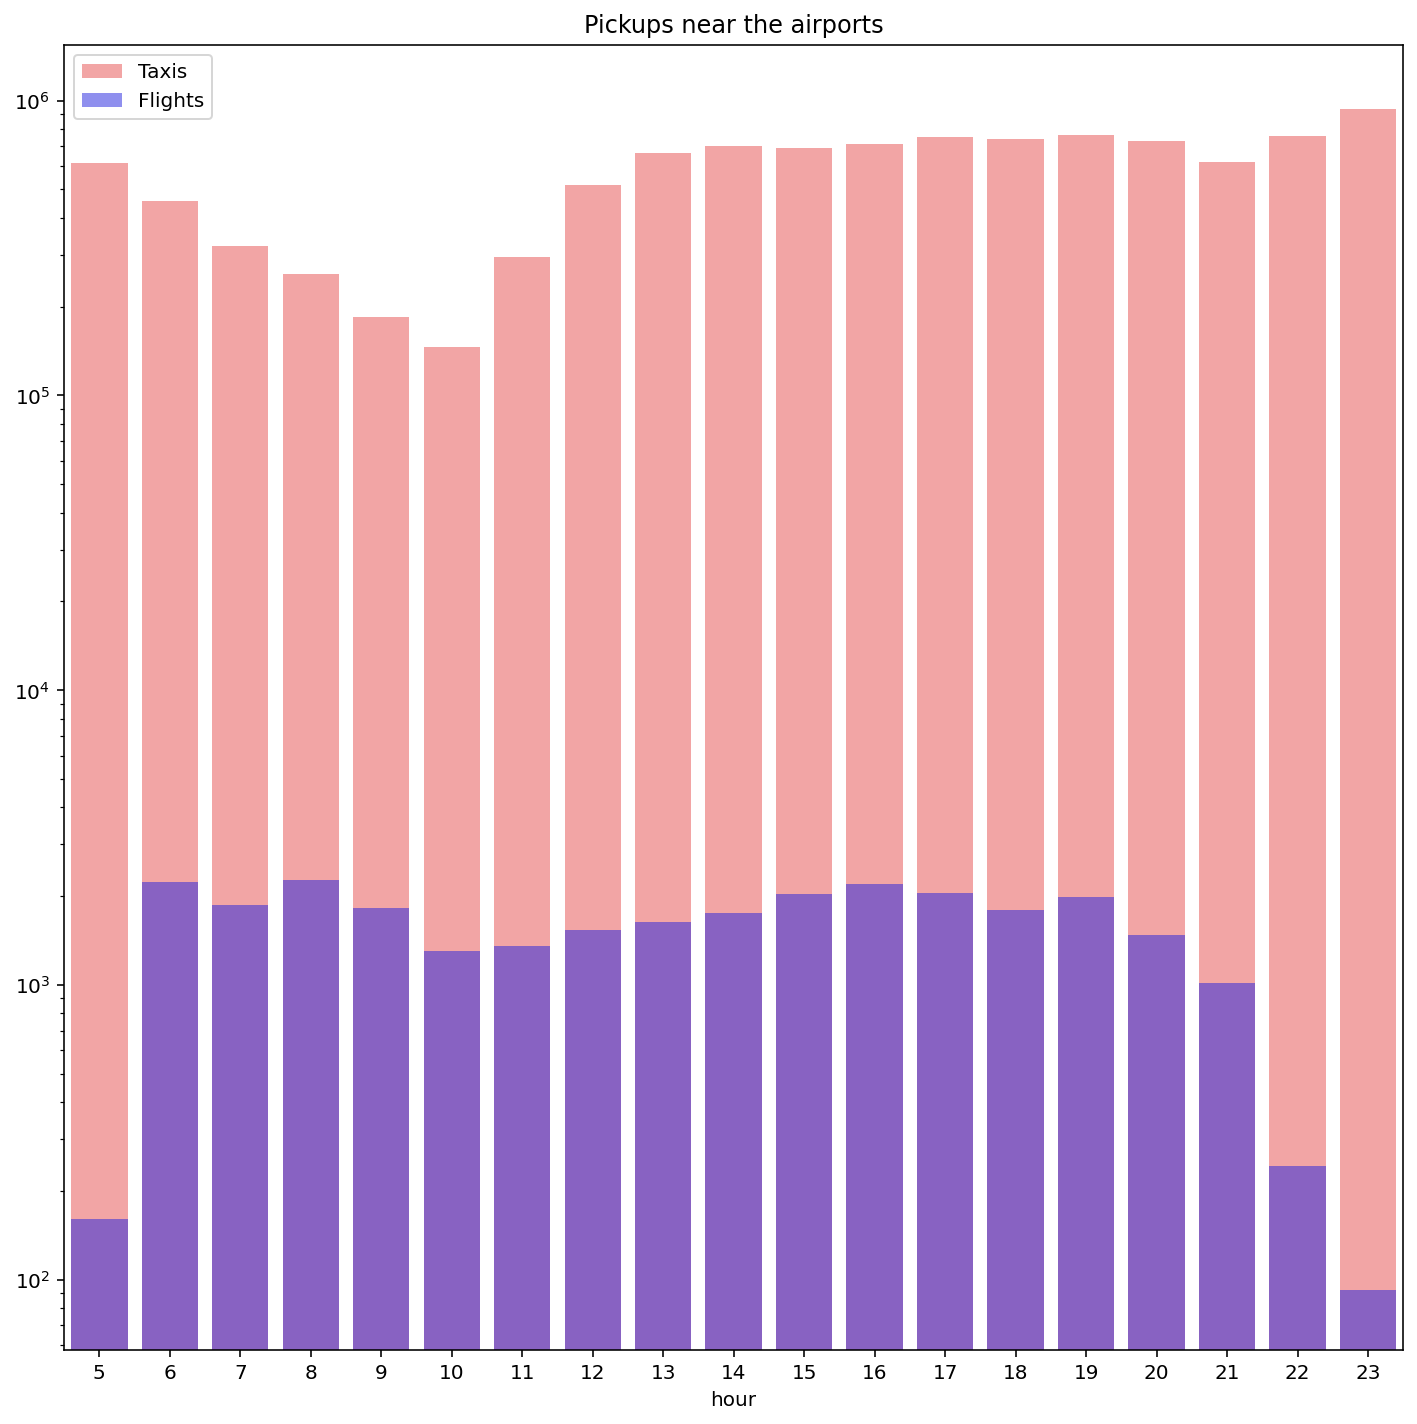

In [32]:
# Plot
f, ax = plt.subplots(figsize=(12, 12))
ax.set(yscale="log")
sns.barplot(x=df.groupby('hourOfDay')['pickup_longitude'].count(
).index, y=df.groupby('hourOfDay')['pickup_longitude'].count().values, color='red', label='Taxis', alpha=0.4)


sns.barplot(x=af.groupby('hour')['flight'].count().index, y=af.groupby(
    'hour')['flight'].count().values, color='blue', label='Flights', alpha=0.5)
ax.legend()
plt.title('Pickups near the airports')

Text(0.5, 1.0, 'Dropoffs near the airports')

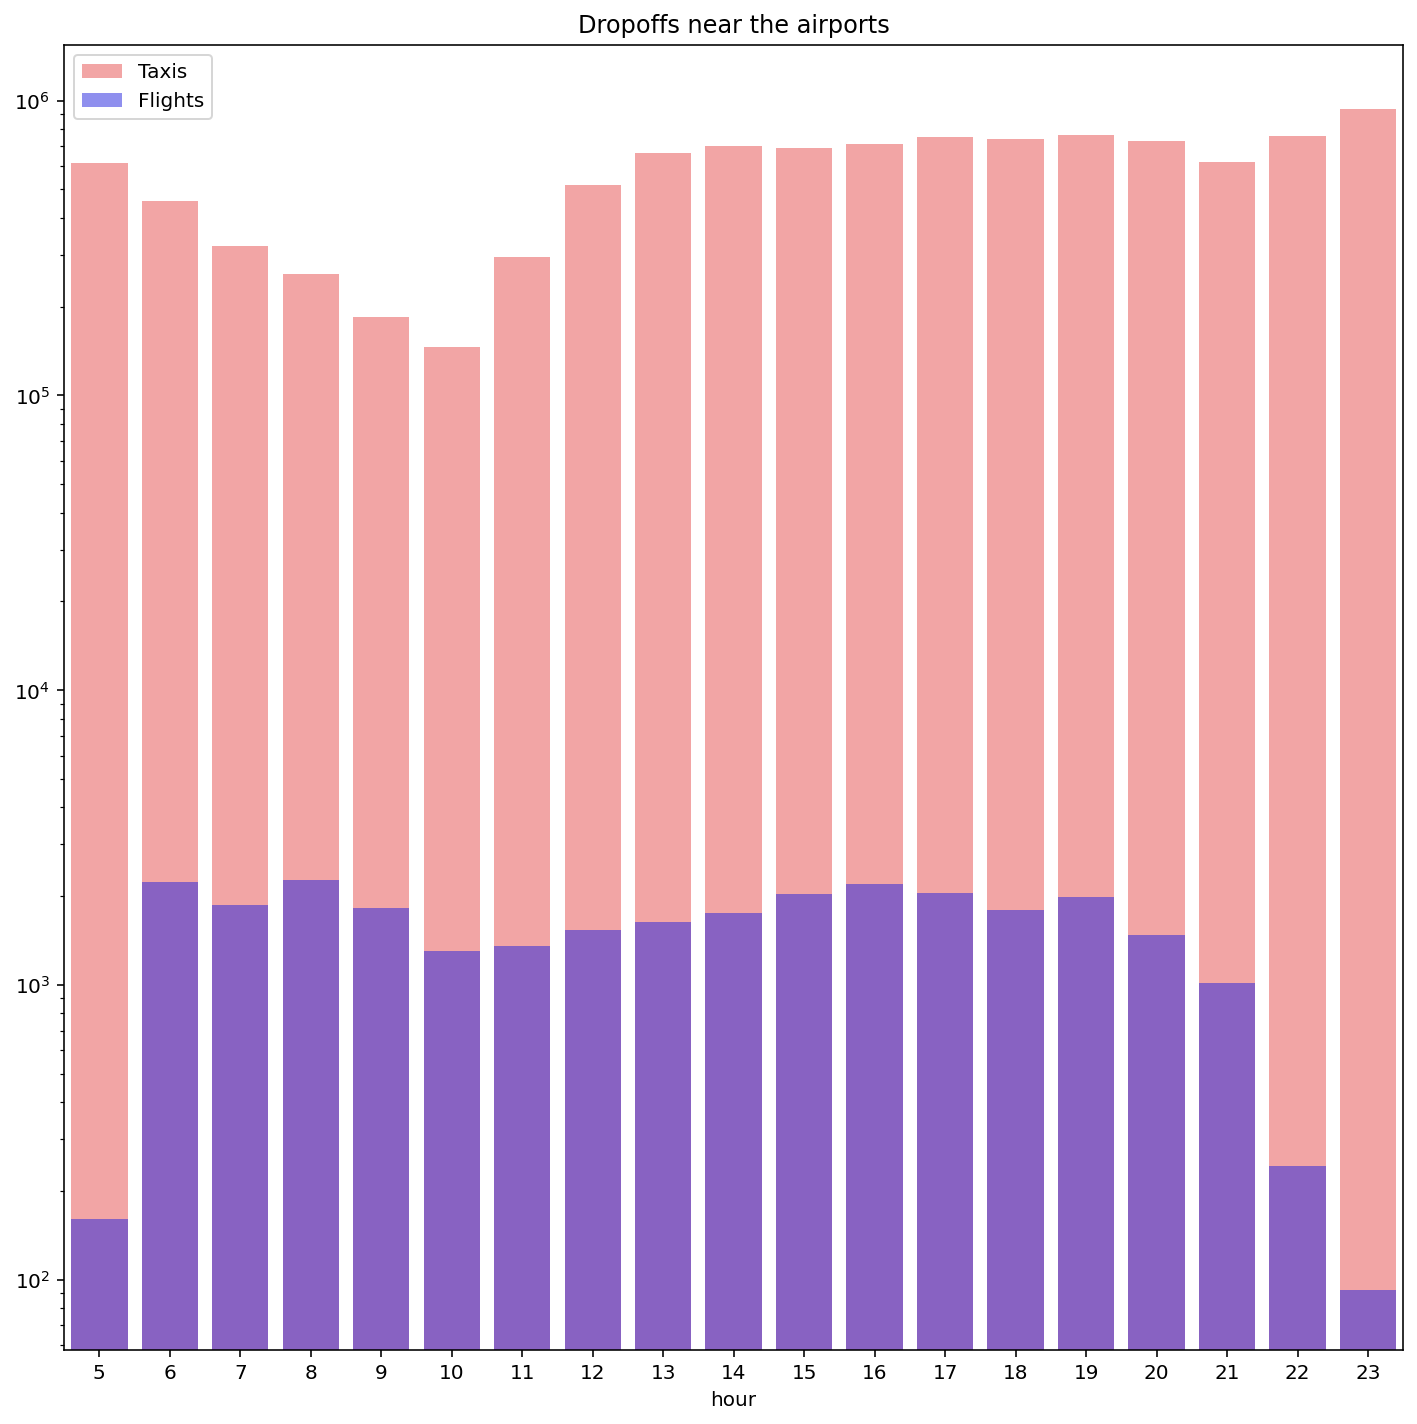

In [31]:
# Plot
f, ax = plt.subplots(figsize=(12, 12))
ax.set(yscale="log")
sns.barplot(x=df.groupby('hourOfDay')['dropoff_longitude'].count(
).index, y=df.groupby('hourOfDay')['dropoff_longitude'].count().values, color='red', label='Taxis', alpha=0.4)


sns.barplot(x=af.groupby('hour')['flight'].count().index, y=af.groupby(
    'hour')['flight'].count().values, color='blue', label='Flights', alpha=0.5)
ax.legend()
plt.title('Dropoffs near the airports')

Text(0.5, 1.0, 'Dropoffs near the airports')

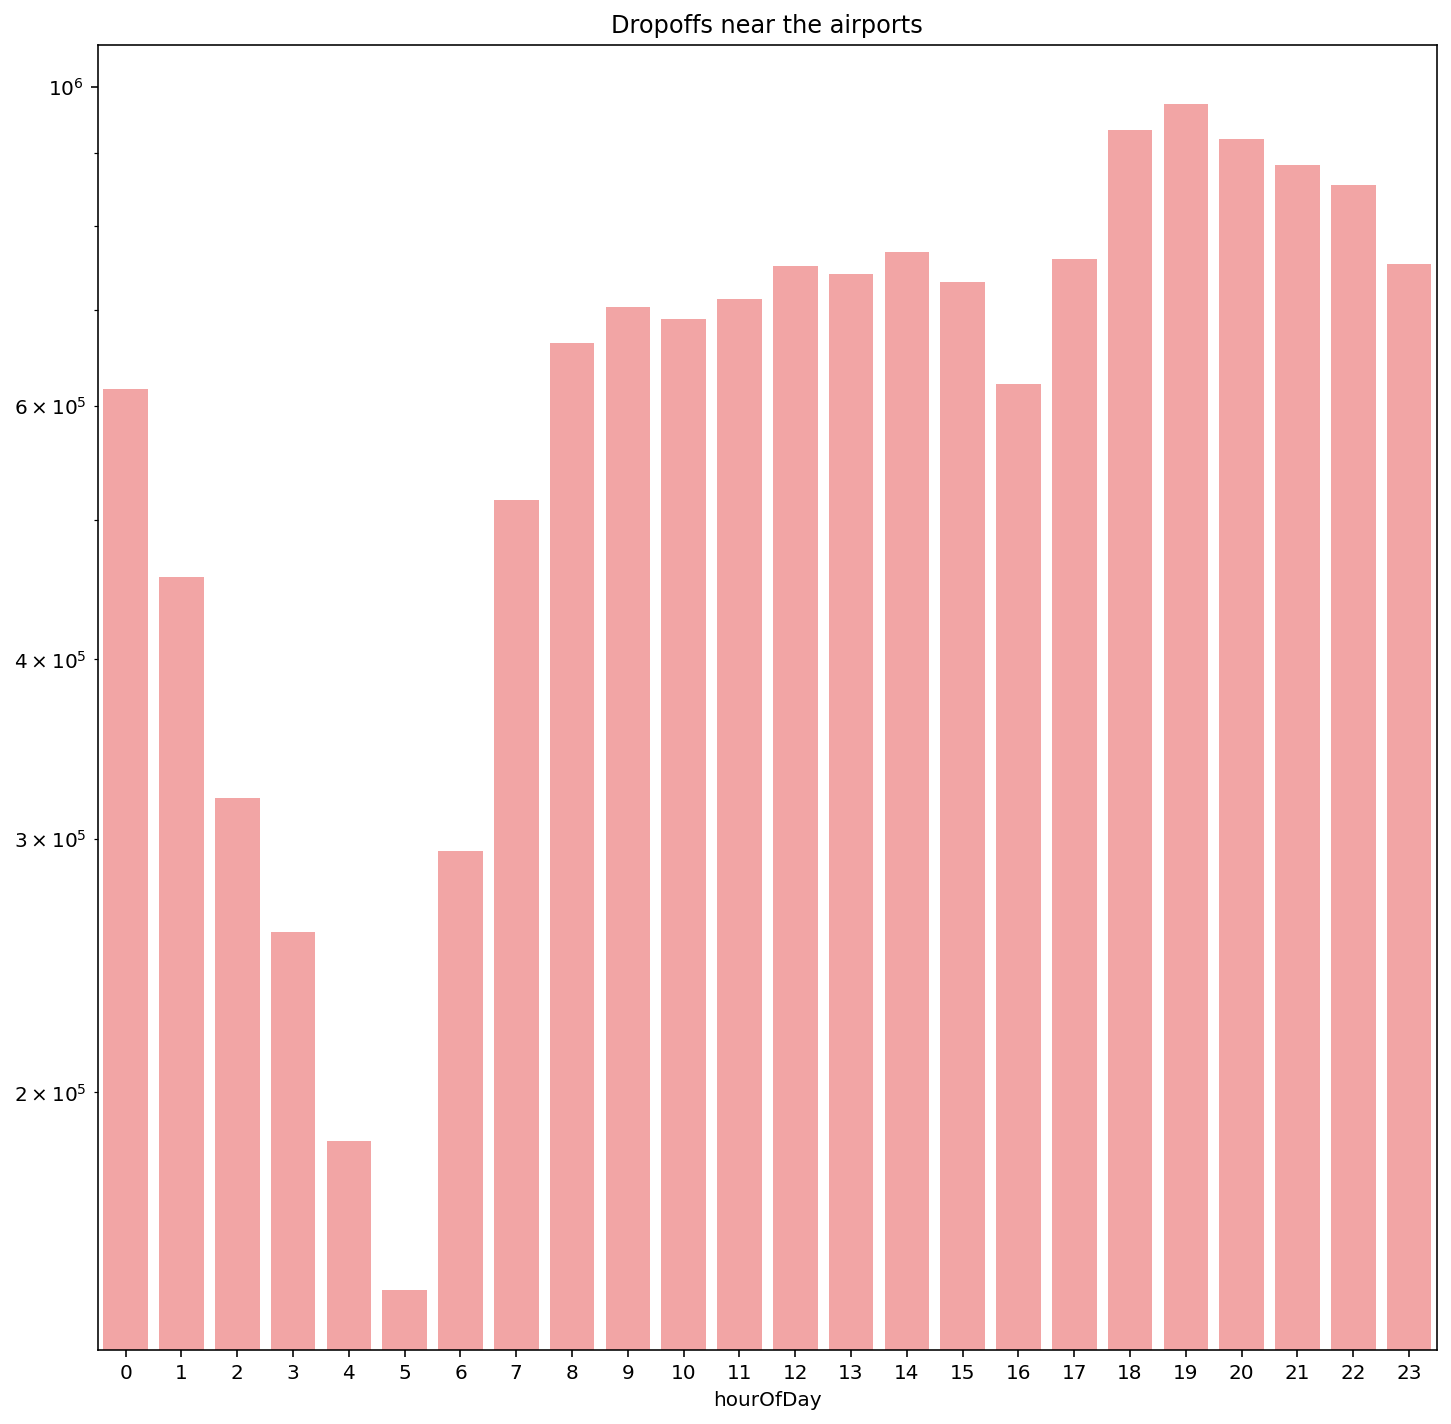

In [30]:
# Plot
f, ax = plt.subplots(figsize=(12, 12))
ax.set(yscale="log")
sns.barplot(x=df.groupby('hourOfDay')['dropoff_longitude'].count(
).index, y=df.groupby('hourOfDay')['dropoff_longitude'].count().values,color='red', label='Taxis', alpha=0.4)

plt.title('Dropoffs near the airports')
